# Ensemble Methods for Instance Segmentation

For a while, I searched online for an easy to use package that could perform what I wanted to do: ensemble a collection of masks together from multiple instance segmentation models to produce a better mask. I wanted to be able to use different models trained on multiple datasets, and also perform data augmentation on images and run in through the same model.

I couldn't find anything that I needed. At least, not anything that was generic enough for my use case. I imagined, however, that something like this should exist! As ensemble methodologies are quite common in classical machine learning models and becoming more and more common in LLM architectures.

But why not for instance segmentation models?

## The Problem

Instance segmentation models are quite powerful. But when it comes to detecting objects in the wild, I have discovered they can be quite brittle.
Maybe if we are classifying a teapot inside a house with perfect lighting, the model works perfectly, sure. But what about detecting obscured leaves in the hot Hawaiian sun, with harsh shadows, fog, rain, and a huge context of other objects in the scene? This is where I have found that instance segmentation models can struggle.

Further, in the case of ensemble classification models, this is quite easy as you can simple "vote" on the most common class. But how do do that when you expect a pixel-wise mask, and for that mask to contain multiple segmentations within it? And when you expect to merge those segmentations into multiple instances of the same class?

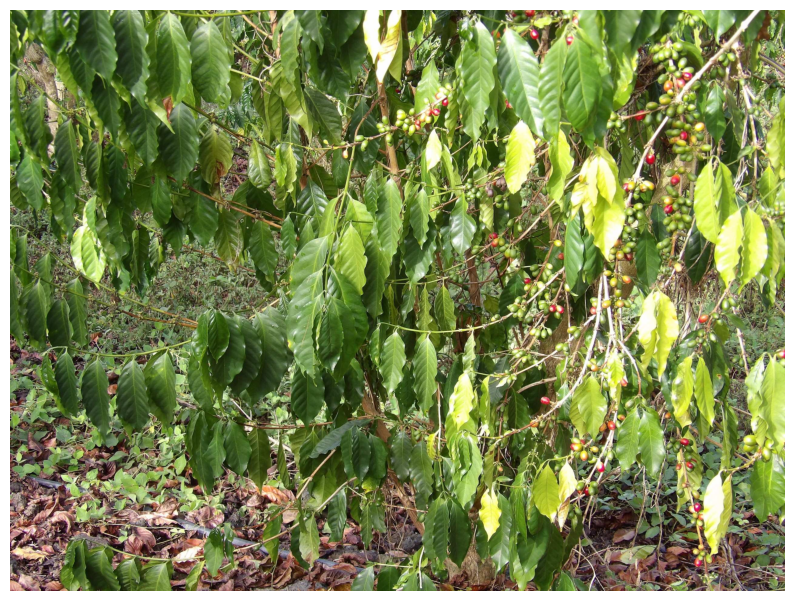

In [5]:
import cv2
from matplotlib import pyplot as plt

frame = cv2.imread('example1.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.axis('off')
plt.show()

As an example, you can see the wide variety of obfuscations. Shadows, leaves on top of other leaves, over exposure, and high contextual noise. I have found that even the famous Segment Anything model struggles with these types of images. I frequently find that it includes shadows and other parts of the background and other leaves in the mask: making annotation quite difficult as well!

## The Solution

As a potential solution, it might not be a bad idea to see if an ensemble of models could produce a better mask once it is combined. That is where the 'ensemble_seg' package comes in. It is a very simple package that takes multiple masks and merges them together to produce a de-duplicated, more accurate mask.

The main idea is to take multiple segmentations (instance segmentations that is) that were produced by different models or from different augmentations of the same image, overlap each one of them together and test how large the overlap is between them, merge them together if they pass the threshold, blend the overlaps together, before finally returning the de-duplicated masks for each instance.

We can see an example of this below where we look at different overlapping contours of the same leaf in an image. I allows SegmentAnything to generate some of the masks, and hand drew some of the others.

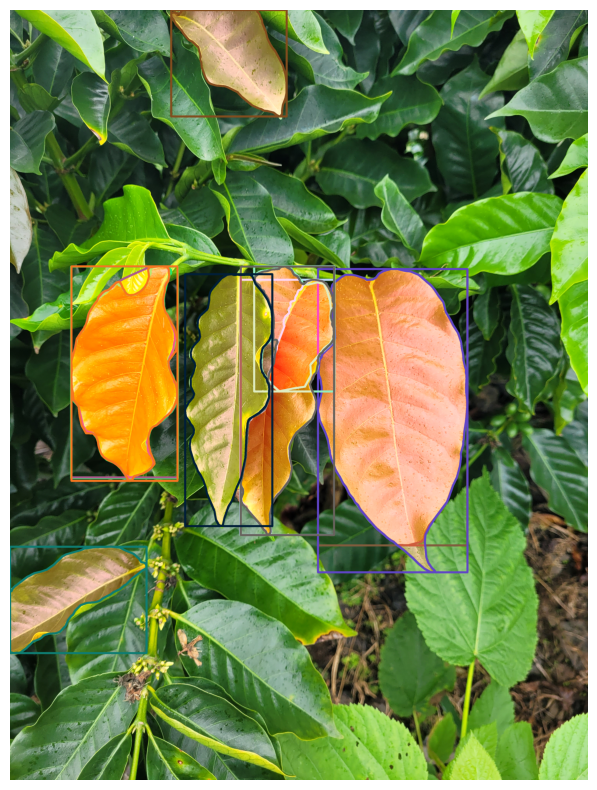

In [10]:
import json
import numpy as np

coco_data = json.load(open('coco.json'))

frame = cv2.imread('frame.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

# Gather the masks and bounding boxes to be passed into the ensemble_seg function
results = []
for annotation in coco_data['annotations']:
    mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
    contour = np.array(annotation['segmentation']).reshape(-1, 2).astype(np.int32)
    cv2.fillPoly(mask, [contour], 255)
    bbox = annotation['bbox']
    results.append({ 'mask': mask, 'bbox': bbox, 'confidence': 1.0 })


visual = frame.copy()
for result in results:
    mask = result['mask'].copy()
    
    contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA)
    color = [np.random.randint(0, 255) for _ in range(3)]
    mask[:, :, 1] = 0
    mask[:, :, 2] = 0
    mask[:, :, 3] = color[2]

    visual = cv2.addWeighted(visual, 1, mask, 0.3, 0)
    visual = cv2.drawContours(visual, [contour], -1, (*color, 255), 10)

    x, y, w, h = cv2.boundingRect(contour)
    visual = cv2.rectangle(visual, (x, y), (x + w, y + h), (*color, 255), 10)

plt.figure(figsize=(10, 10))
plt.imshow(visual)
plt.axis('off')
plt.show()

Clearly, some masks overlap, are smaller, or are larger than others. Some are even completely seperated from the others where potentially only a single model was able to detect it. This is where the ensemble method can come in and help us merge these masks together.

Very simply, we can take the `results` array and pass it into the `merge_masks` function. We default the confidence to 1.0 to give equal weight to all masks. But if this were actual models, you could customize the confidence to either give the confidence that the model itself gave, or a custom confidence depending on how much you trust the specific model.

In [13]:
def visualize_results(frame, groups):
    visual = frame.copy()

    for group, mask in groups:
        
        # we assume only one mask in the group
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA)
        
        color = [np.random.randint(0, 255) for _ in range(3)]
        
        mask[:, :, 1] = 0
        mask[:, :, 2] = 0
        mask[:, :, 3] = color[2]

        visual = cv2.addWeighted(visual, 1, mask, 0.3, 0)
        visual = cv2.drawContours(visual, contours, -1, (*color, 255), 10)
        
        # draw bounding box
        x, y, w, h = cv2.boundingRect(contours[0])
        visual = cv2.rectangle(visual, (x, y), (x + w, y + h), (*color, 255), 10)

    plt.figure(figsize=(10, 10))
    plt.imshow(visual)
    plt.axis('off')
    plt.show()

Merged Group: (3, 4)
Merged Group: (8,)
Merged Group: (5, 6, 7)
Merged Group: (10,)
Merged Group: (0, 1, 2)
Merged Group: (9,)


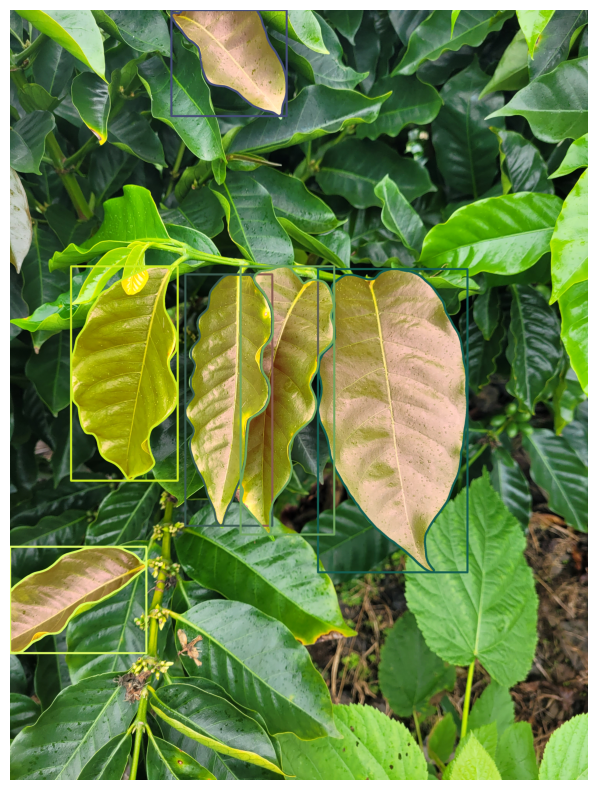

In [15]:
from ensemble_seg import merge_masks

groups = list(merge_masks(results, area_diff_percent=0.8, iou_threshold=0.3))

for group in groups:
    print('Merged Group:', group[0])
    
visualize_results(frame, groups)

Just like that! The instances are merged together. Each group printed avoid represents the index of the `results` array that was merged together. Now lets visualize the results of the merged masks.

Now you can see that only 6 instances remain, even the masks where there was no overlapping masks. Playing around with the parameters, this can produce very different results. In this example, the leave in the center of the image has multiple overlapping masks, but one of the masks is signficantly smaller than the other.

Because our parameters relaxed at were: `area_diff_percent=0.8, iou_threshold=0.3`, this means that the threshold to merge was that masks had only to be 80% of the size of the other masks, and have an IoU of 0.3. This is quite a relaxed threshold!

But maybe we want to be more strict because we don't believe that a mask so small should be merged in with the other masks. We can change the parameters to `area_diff_percent=0.5, iou_threshold=0.5` and see the results.

Merged Group: (6,)
Merged Group: (3, 4)
Merged Group: (8,)
Merged Group: (5, 7)
Merged Group: (10,)
Merged Group: (0, 1, 2)
Merged Group: (9,)


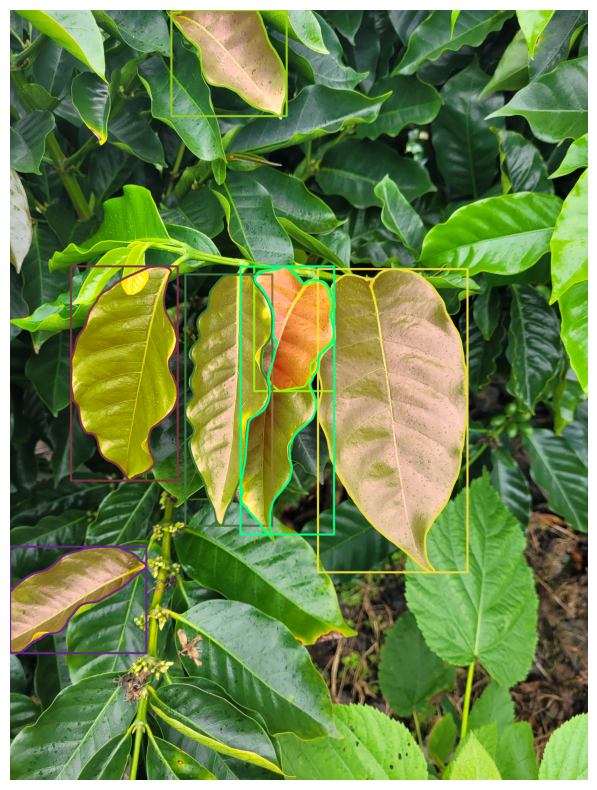

In [16]:
groups = list(merge_masks(results, area_diff_percent=0.5, iou_threshold=0.5))

for group in groups:
    print('Merged Group:', group[0])
    
visualize_results(frame, groups)

Playing with these settings can produce very different results and should be customized depending on the specific use case. Having very relaxed settings will produce less overall instances but may benefit in datasets where obfuscations are common and models are not as accurate. Having very strict settings will produce more instances but may benefit in datasets where obfuscations are rare and models are more accurate.

## Conclusion

Very simple package to do a very simple thing in order to not have to write code twice. I developed this as part of the [Ainascan Project](https://ainascan.com) to help with improving the accuracy of the instance segmentation models. We need to have high accuracy of segmentation as users need to be able to take a picture quickly and have it segmented well enough to detect diseases and defects that may be present on the "hard to segment" parts of the plant: i.e. the edges, tips, and shadowed parts of the leaves.